# Logistic regression II: PneumoniaMNIST

In this part, you will train a logistic regression model with a (slightly) more challenging dataset included in the [MedMNIST collection](https://medmnist.com/). We will work with the `PneumoniaMNIST` dataset, a set of 5856 small $28\times{}28$ chest X-ray scans labeled as having pneumonia (class 1) or not (class 0). To access this dataset you will need to install the Python `medmnist` package running in the terminal
```bash
pip install medmnist
```

You have to train a logistic regression model with the scans from the training split in order to predict the presence of pneumonia in new, unseen scans (i.e., the scans of the test split). You are free to proceed as you want (no guidance will be provided here), and you can reuse and modify as much code as you want from your work in `Logistic regression I.ipynb`.

You should, however, follow a general scheme of proper data analysis: data visualization, data pre-processing, model implementation, training, model evaluation, and qualitative analysis of results. It is **IMPORTANT** that you describe interesting findings and how the new results compare to the results you got with the MNIST dataset.


In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np
import torch as th
from torchvision.utils import make_grid

from medmnist import PneumoniaMNIST, BreastMNIST

from sklearn import metrics

plt.rcParams["figure.figsize"] = (9, 6)

## Dataset loading

We will use the MNIST dataset available in `torchvision`:

In [2]:
mnist_train = PneumoniaMNIST(split="train", root="./datasets", download=True)
mnist_test = PneumoniaMNIST(split="test", root="./datasets", download=True)

0it [00:00, ?it/s]

Using downloaded and verified file: ./datasets/pneumoniamnist.npz


In [3]:
mnist_train.imgs.shape, mnist_train.labels.shape, mnist_test.imgs.shape, mnist_test.labels.shape

((4708, 28, 28), (4708, 1), (624, 28, 28), (624, 1))

As we did in the previous assignment, we vectorize all the images (concatenating their pixels in a sigle row) and consider that they are elements of the Euclidean space $\mathbb{R}^{784}$. Also, we extract their target values.

In [4]:
data_train = th.reshape(th.tensor(mnist_train.imgs), (-1, 28**2))
data_test = th.reshape(th.tensor(mnist_test.imgs), (-1, 28**2))

target_train = th.tensor(mnist_train.labels).squeeze()
target_test = th.tensor(mnist_test.labels).squeeze()

print(data_train.shape, data_test.shape)

torch.Size([4708, 784]) torch.Size([624, 784])


## Data preprocessing


In [5]:
data_train = data_train.data / 255.0
data_test = data_test.data / 255.0

___

## Data visualization

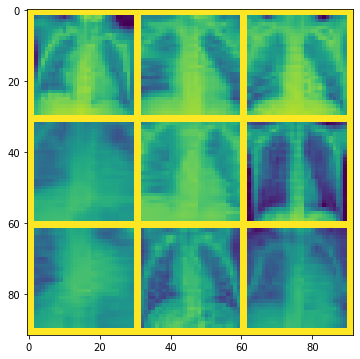

In [6]:
# Plot some samples
example = data_train[:9]
example = example.reshape(-1,28,28)
plt.imshow(make_grid(example[:,None]*255, nrow=3, pad_value=255)[0])
plt.show()

___

## Logistic regression


In [7]:
def logistic_regression(x: th.Tensor, weights: th.Tensor, bias: th.Tensor) -> th.Tensor:
    return th.sigmoid(x @ weights + bias)

In [8]:
def binary_cross_entropy(p_hat, y):
    losses = th.where(y==1, -th.log(p_hat), -th.log(1-p_hat))
    return losses.mean()

___

## Training

final loss: 0.12203739583492279


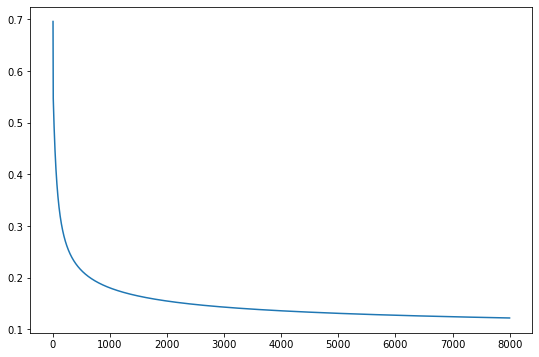

In [9]:
weights = th.randn(784) / 784
weights.requires_grad_()
bias = th.tensor(0.0, requires_grad=True)
eta = 0.03
losses = []
ws = [weights.detach().clone()]
bs = [bias.detach().clone()]

num_iterations = 8000

for _ in range(num_iterations):
    p_hat = logistic_regression(data_train, weights, bias)
    loss = binary_cross_entropy(p_hat, target_train)

    loss.backward()
    with th.no_grad():
        weights[...] = weights - eta * weights.grad
        bias[...] = bias - eta * bias.grad
        weights.grad = None
        bias.grad = None
    
    losses.append(loss.detach())
    ws.append(weights.detach().clone())
    bs.append(bias.detach().clone())
    if (_ > 3) and (th.abs(losses[-1] - losses[-2]) < 1e-8):
        break

%matplotlib inline

plt.figure(figsize=(9, 6))
plt.plot(losses)
print('final loss:', float(losses[-1]))

The final loss is bigger than MNIST dataset model loss. Because this set is more complicated and logistic regression performs not so well as in MNIST.

And also, the dataset is smaller so the training process is not as sufficient as for MNIST.

___

Save the weight and the bias after training the best model you got. We will use that model in the next section for evaluation.

**INCLUDE THIS FILE IN THE FINAL SUBMISSION FILE** so I can run the evaluation with your model.

In [10]:
th.save({"weights": weights.detach(), "bias": bias.detach()}, "best_model_pneumonia.pt")

___

## Model evaluation and analysis

In [11]:
model = th.load("best_model_pneumonia.pt")
weights = model["weights"]
bias = model["bias"]

In [12]:
test_pred = logistic_regression(data_test, weights, bias)
test_pred_label = (test_pred>0.5).int()*1
print(metrics.accuracy_score(target_test, test_pred_label)) # Return the ratio of correctly classified samples

0.8317307692307693


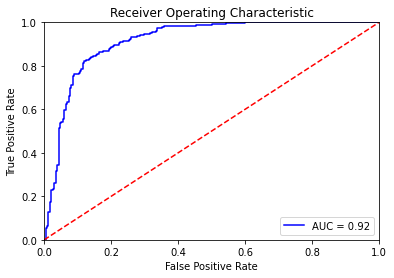

AUC: 0.91537365768135


In [13]:
# roc curve
fpr, tpr, threshold = metrics.roc_curve(target_test, test_pred)
roc_auc = metrics.auc(fpr, tpr)
# plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# area under roc curve
print('AUC:',roc_auc)

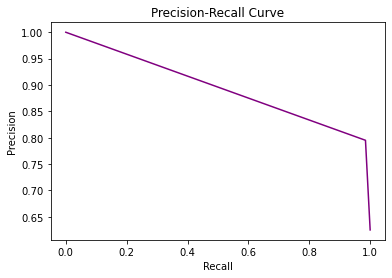

average precision score: 0.8762389322056297


In [14]:
#calculate precision and recall
precision, recall, thresholds = metrics.precision_recall_curve(target_test, test_pred_label)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

# Calculate precision score
print('average precision score:',metrics.precision_score(target_test, test_pred_label, average='macro'))

The model has a AUC value of 0.915, it is not as good as the model for MNIST, but still ok for this dataset. Which means logistic regression works for this problem.

Highest 9 false positive case prob: tensor([1.0000, 0.9998, 0.9997, 0.9995, 0.9992, 0.9987, 0.9986, 0.9985, 0.9980])
All false negetive case prob: tensor([0.1750, 0.1850, 0.2778, 0.3383, 0.3885, 0.4099])


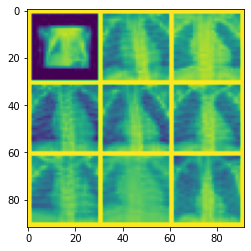

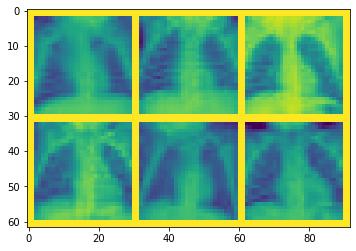

In [15]:
# evaluate hard case
hard_caseFP_mask = (test_pred > 0.5) & (target_test == False)
hard_caseFN_mask = (test_pred < 0.5) & (target_test == True)
sorted_FP_prob, indices_FP = th.sort(test_pred[hard_caseFP_mask],descending=True)
sorted_FN_prob, indices_FN = th.sort(test_pred[hard_caseFN_mask],descending=False)
FP_case_sorted = data_test[hard_caseFP_mask][indices_FP,:]
FN_case_sorted = data_test[hard_caseFN_mask][indices_FN,:]
print('Highest 9 false positive case prob:', sorted_FP_prob[:9])
print('All false negetive case prob:', sorted_FN_prob[:])

# Plot 9 samples of class 0 FP
FP_case_sorted = FP_case_sorted.reshape(-1,28,28)
plt.imshow(make_grid(FP_case_sorted[:9,None]*255, nrow=3, pad_value=255)[0])
plt.show()

# Plot all samples of class 1 FN
FN_case_sorted = FN_case_sorted.reshape(-1,28,28)
plt.imshow(make_grid(FN_case_sorted[:,None]*255, nrow=3, pad_value=255)[0])
plt.show()

Sorry I cannot say what X-ray scans might have pneumonia or not....

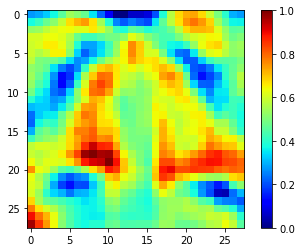

In [16]:
# Plot weights graph
plt.jet()
weights = weights.reshape(-1,28,28)
sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=0, vmax=1))
plt.colorbar(sm)
plt.imshow(make_grid(weights[:,None]*255, nrow=3, pad_value=255)[0])
plt.show()


Seeing from the weights graph, the red part look like lung scan structure. And we see the lower part has dark red which means pneumonia scan will show symptons in their lower part lung. This might be a significant feature.